# FinistR : bootcamp R à Roscoff

## JIT compilation with pytorch

We study Just In Time (JIT) compilation with pytorch. This tutorial is to be compared with [JIT compilation in pytorch](https://stateofther.github.io/finistR2023/jit-example-pln-jax.html) where much more explanations are given.

## Set-up

References to pytorch JIT compilation, by order of difficulty:

-   [pytorch jit official
    documentation](https://pytorch.org/docs/stable/jit.html)
-   [pytorch jit trace
    documentation](https://pytorch.org/docs/stable/generated/torch.jit.trace.html)
-   [TorchScript official
    tutorial](https://pytorch.org/tutorials/beginner/Intro_to_TorchScript_tutorial.html)
-   [pytorch jit intermediate
    guide](https://residentmario.github.io/pytorch-training-performance-guide/jit.html)
-   [pytorch jit intermediate / advanced
    guide](https://lernapparat.de/jit-optimization-intro/)
-   [pytorch jit advanced
    guide](https://lernapparat.de/jit-runtime-overview)

Make necessary imports

In [1]:
import torch
import numpy as np
import math
import pyPLNmodels
import numpy as np
import matplotlib.pyplot as plt
from pyPLNmodels.models import PlnPCAcollection, Pln
from pyPLNmodels.oaks import load_oaks

Using a GPU.


**Note**: **We use pytorch GPU !** JIT compilation is particularly efficient on GPU. On this particular example, we were not able to see any speed up on CPU between jitted code and non-jitted code. We suppose it might be possible to get a CPU speed up on other case study, considering neural networks for example..

In [2]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.set_default_dtype(torch.float32)
myfloat = np.float32

cuda


In [3]:
oaks = load_oaks()
Y = np.asarray(oaks['counts']).astype(myfloat)
Y = np.repeat(Y, 100, axis=0) # make data bigger to feel the speed up
O = np.log(oaks['offsets']).astype(myfloat)
O = np.repeat(O, 100, axis=0) # make data bigger to feel the speed up
X = np.ones([Y.shape[0],1]).astype(myfloat)

N_iter = 5000
lr = 1e-2

## Original non-jitted version

We reuse the code from [PLN in pytorch](https://stateofther.github.io/finistR2023/torch_Python-PLN.html).

In [4]:
def _log_stirling(integer: torch.Tensor) -> torch.Tensor:
    integer_ = integer + (integer == 0)  # Replace 0 with 1 since 0! = 1!
    return torch.log(torch.sqrt(2 * np.pi * integer_)) + integer_ * torch.log(integer_ / math.exp(1))

class PLN:
    Y : torch.Tensor
    O : torch.Tensor
    X : torch.Tensor
    n : int
    p : int
    d : int
    M : torch.Tensor
    S : torch.Tensor
    B : torch.Tensor
    Sigma : torch.Tensor
    Omega : torch.Tensor
    device : torch.device

      ## Constructor
    def __init__(self, Y: np.array, O: np.array, X: np.array, device:
    torch.device) : 
        self.Y = torch.tensor(Y)
        self.Y = self.Y.to(device)
        self.O = torch.tensor(O)
        self.O = self.O.to(device)
        self.X = torch.tensor(X)
        self.X = self.X.to(device)
        self.n, self.p = Y.shape
        self.d = X.shape[1]
        ## Variational parameters
        self.M = torch.full(Y.shape, 0.0, requires_grad=True,
            device=device)
        self.S = torch.full(Y.shape, 1.0, requires_grad=True, device=device)
        ## Model parameters
        self.B = torch.zeros(self.d, self.p, requires_grad=True, device=device)
        self.Sigma = torch.eye(self.p, device=device)
        self.Omega = torch.eye(self.p, device=device)

        self.device = device

    def get_Sigma(self) :
      return 1/self.n * (self.M.T @ self.M + torch.diag(torch.sum(self.S**2, dim = 0)))

    def get_ELBO(self): 
      S2 = torch.square(self.S)
      XB = self.X @ self.B
      A = torch.exp(self.O + self.M + XB + S2/2)

      elbo = self.n/2 * torch.logdet(self.Omega)
      elbo += torch.sum(- A + self.Y * (self.O + self.M + XB) + .5 * torch.log(S2))
      elbo -= .5 * torch.trace(self.M.T @ self.M + torch.diag(torch.sum(S2, dim = 0)) @ self.Omega)
      elbo += .5 * self.n * self.p  - torch.sum(_log_stirling(self.Y))
      return elbo

    def fit(self, N_iter, lr, tol=1e-8) :
      self.ELBO = np.zeros(N_iter, dtype=myfloat)
      optimizer = torch.optim.Adam([self.B, self.M, self.S], lr=lr)
      for i in range(N_iter):
        ## reinitialize gradients
        optimizer.zero_grad()

        ## compute current ELBO
        loss = -self.get_ELBO()

        ## backward propagation and optimization
        loss.backward()
        optimizer.step()

        ## update parameters with close form
        self.Sigma = self.get_Sigma()
        self.Omega = torch.inverse(self.Sigma)

        objective = -loss.item()
        self.ELBO[i] = objective

Let’s create the PLN object:

In [5]:
%%time
myPLN = PLN(Y, O, X, device)

CPU times: user 523 ms, sys: 67 ms, total: 590 ms
Wall time: 134 ms


and run the learning process:

In [6]:
%%time
myPLN.fit(N_iter, lr = lr, tol=1e-8)

CPU times: user 34.5 s, sys: 193 ms, total: 34.7 s
Wall time: 35.3 s


## Eager graph mode

There are two ways to create the computational graph: **eager
execution** and **graph execution**. The default mode in pytorch is
**eager**, this means the computational graph is created at each forward
pass in the graph. On the other hand, the **graph** mode adds an
additional compilation step which builds the graph only once and lets
the computations be done at a lower level.

JIT (Just In Time) compilation is the process that builds an
Intermediate Representation (IR) of the graph. This is the additional compilation step mentioned above.

Using **graph mode**, we gain:

-   efficiency since the graph is precomputed and can be optimized to
    factorize redundant operations or delete useless operations.
-   portability since this IR can be reused in another language.

However, we lose:

-   flexibility since we are tied to fixed array sizes, we cannot easily
    use control flows, …

There are two ways in pytorch to JIT our code, hence, there are two ways to use require the **graph mode**. We study these two ways in the next sections.

## JIT with `torch.jit.script`

By reading the above mentioned references, we get that we cannot jit the
`fit` function. Some reasons are:

-   `N_iter` is variable at compilation time (shape might change depending on input).
-   the pytorch optimizer’s operations cannot be jitted.
-   `torch.jit.script` cannot handle control flow or loops.

In [7]:
class jitPLN(torch.jit.ScriptModule) :
    Y : torch.Tensor
    O : torch.Tensor
    X : torch.Tensor
    n : int
    p : int
    d : int
    M : torch.Tensor
    S : torch.Tensor
    B : torch.Tensor
    Sigma : torch.Tensor
    Omega : torch.Tensor
    device : torch.device

      ## Constructor
    def __init__(self, Y: np.array, O: np.array, X: np.array, device: torch.device) : 
        super().__init__()
        self.Y = torch.tensor(Y)
        self.Y = self.Y.to(device)
        self.O = torch.tensor(O)
        self.O = self.O.to(device)
        self.X = torch.tensor(X)
        self.X = self.X.to(device)
        self.n, self.p = Y.shape
        self.d = X.shape[1]
        ## Variational parameters
        self.M = torch.full(Y.shape, 0.0, requires_grad=True,
            device=device)
        self.S = torch.full(Y.shape, 1.0, requires_grad=True, device=device)
        ## Model parameters
        self.B = torch.zeros(self.d, self.p, requires_grad=True, device=device)
        self.Sigma = torch.eye(self.p, device=device)
        self.Omega = torch.eye(self.p, device=device)

        self.device = device

    @torch.jit.script_method
    def _log_stirling(self, integer):
        integer_ = integer + (integer == 0)  # Replace 0 with 1 since 0! = 1!
        return torch.log(torch.sqrt(2 * np.pi * integer_)) + integer_ * torch.log(integer_ / math.exp(1))

    @torch.jit.script_method
    def get_Sigma(self) :
      return 1/self.n * (self.M.T @ self.M + torch.diag(torch.sum(self.S**2, dim = 0)))

    @torch.jit.script_method
    def get_inv(self, S):
      return torch.inverse(S)

    @torch.jit.script_method
    def get_ELBO(self): 
      S2 = torch.square(self.S)
      XB = self.X @ self.B
      A = torch.exp(self.O + self.M + XB + S2/2)

      elbo = self.n/2 * torch.logdet(self.Omega)
      elbo += torch.sum(- A + self.Y * (self.O + self.M + XB) + .5 * torch.log(S2))
      elbo -= .5 * torch.trace(self.M.T @ self.M + torch.diag(torch.sum(S2, dim = 0)) @ self.Omega)
      elbo += .5 * self.n * self.p  - torch.sum(self._log_stirling(self.Y))
      return elbo

def fit(pln, N_iter, lr, tol = 1e-8) :
    ELBO = np.zeros(N_iter, dtype=myfloat)
    optimizer = torch.optim.Adam([pln.B, pln.M, pln.S], lr = lr)

    for i in range(N_iter):
        ## reinitialize gradients
        optimizer.zero_grad()

        ## compute current ELBO
        loss = - pln.get_ELBO()

        ## backward propagation and optimization
        loss.backward()
        optimizer.step()

        ## update parameters with close form
        pln.Sigma = pln.get_Sigma()
        pln.Omega = pln.get_inv(pln.Sigma)

        objective = -loss.item()
        ELBO[i] = objective
        
    return ELBO

Let’s create the jitted PLN object:

In [8]:
%%time
myjitPLN = jitPLN(Y, O, X, device)

CPU times: user 194 ms, sys: 4.8 ms, total: 199 ms
Wall time: 19.4 ms


and run the learning process:

In [9]:
%%time
scriptELBO = fit(myjitPLN, N_iter, lr = lr, tol = 1e-8)

/home/hugo/anaconda3/envs/finistR2023/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: operator() profile_node %760 : int[] = prim::profile_ivalue(%dims.24)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


CPU times: user 27.3 s, sys: 164 ms, total: 27.4 s
Wall time: 28.2 s


## JIT with `torch.jit.trace`

Here we use `torch.jit.trace` over each of the computational functions, the PLN class is
just a container for the objects. The previous limitations from `torch.jit.script` are still present, notably, we cannot jit the main `for` loop.

In [10]:
class tracejitPLN:
    Y : torch.Tensor
    O : torch.Tensor
    X : torch.Tensor
    n : torch.Tensor
    p : torch.Tensor
    d : torch.Tensor
    M : torch.Tensor
    S : torch.Tensor
    B : torch.Tensor
    Sigma : torch.Tensor
    Omega : torch.Tensor
    device : torch.device

      ## Constructor
    def __init__(self, Y: np.array, O: np.array, X: np.array, device: torch.device) : 
        self.Y = torch.tensor(Y)
        self.Y = self.Y.to(device)
        self.O = torch.tensor(O)
        self.O = self.O.to(device)
        self.X = torch.tensor(X)
        self.X = self.X.to(device)
        self.n, self.p = Y.shape
        self.n = torch.tensor(self.n)
        self.p = torch.tensor(self.p)
        self.d = X.shape[1]
        ## Variational parameters
        self.M = torch.full(Y.shape, 0.0, requires_grad=True,
            device=device)
        self.S = torch.full(Y.shape, 1.0, requires_grad=True, device=device)
        ## Model parameters
        self.B = torch.zeros(self.d, self.p, requires_grad=True, device=device)
        self.Sigma = torch.eye(self.p, device=device)
        self.Omega = torch.eye(self.p, device=device)
        self.device = device

Let’s create the PLN object and the jitted functions:

In [11]:
%%time
mytracePLN = tracejitPLN(Y, O, X, device)

def _log_stirling(integer):
    integer_ = integer + (integer == 0)  # Replace 0 with 1 since 0! = 1!
    return torch.log(torch.sqrt(2 * np.pi * integer_)) + integer_ * torch.log(integer_ / math.exp(1))

traced_logstirling = torch.jit.trace(_log_stirling, (mytracePLN.Y))

def get_ELBO(S, X, B, O, M, n, Omega, Y, p): 
    S2 = torch.square(S)
    XB = X @ B
    A = torch.exp(O + M + XB + S2/2)

    elbo = n/2 * torch.logdet(Omega)
    elbo += torch.sum(- A + Y * (O + M + XB) + .5 * torch.log(S2))
    elbo -= .5 * torch.trace(M.T @ M + torch.diag(torch.sum(S2, dim = 0)) @ Omega)
    elbo += .5 * n * p  - torch.sum(traced_logstirling(Y))
    return elbo

traced_getELBO = torch.jit.trace(get_ELBO, (mytracePLN.S, mytracePLN.X, mytracePLN.B, mytracePLN.O, mytracePLN.M,
    mytracePLN.n, mytracePLN.Omega, mytracePLN.Y, mytracePLN.p))

def get_Sigma(n, M, S) :
    return 1/n * (M.T @ M + torch.diag(torch.sum(S**2, dim = 0)))

traced_getSigma = torch.jit.trace(get_Sigma, (mytracePLN.n, mytracePLN.M, mytracePLN.S))

def get_inv(S):
    return torch.inverse(S)

traced_getInv = torch.jit.trace(get_inv, get_Sigma(mytracePLN.n, mytracePLN.M, mytracePLN.S))

CPU times: user 401 ms, sys: 4.63 ms, total: 406 ms
Wall time: 56 ms


/home/hugo/anaconda3/envs/finistR2023/lib/python3.9/site-packages/torch/jit/_trace.py:154: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  if a.grad is not None:


In [12]:
def tracefit(pln, N_iter, lr, tol = 1e-8) :

    ELBO = np.zeros(N_iter, dtype=myfloat)
    optimizer = torch.optim.Adam([pln.B, pln.M, pln.S], lr = lr)

    for i in range(N_iter):
        ## reinitialize gradients
        optimizer.zero_grad()

        ## compute current ELBO
        loss = -traced_getELBO(pln.S, pln.X, pln.B, pln.O, pln.M,
            pln.n, pln.Omega, pln.Y, pln.p)

        ## backward propagation and optimization
        loss.backward()
        optimizer.step()

        ## update parameters with close form
        pln.Sigma = traced_getSigma(pln.n, pln.M, pln.S)
        pln.Omega = traced_getInv(pln.Sigma)

        objective = -loss.item()
        ELBO[i] = objective
        
    return ELBO

and run the learning process:

In [13]:
%%time
traceELBO = tracefit(mytracePLN, N_iter, lr = lr, tol = 1e-8)

CPU times: user 25.6 s, sys: 171 ms, total: 25.8 s
Wall time: 26.5 s


## Conclusion

We check that we get the same results with each method:

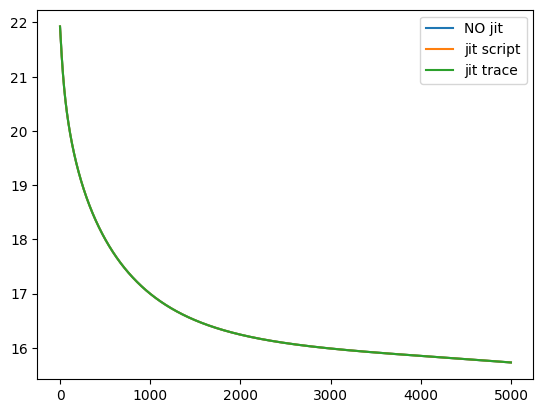

In [14]:
plt.plot(np.log(-myPLN.ELBO), label='NO jit')
plt.plot(np.log(-scriptELBO), label='jit script')
plt.plot(np.log(-traceELBO), label='jit trace')
plt.legend()
plt.show()

- We see that jit script and jit trace reduce computation time by a few second over the
non jitted code. Hence, jit compilation in
pytorch can be interesting but induces strict limitations that the user
must be aware of.

- We should try to consider a more involved problem computationally
speaking (bigger input data, computations involving neural networks, …)